# 1. Configuration


## 1.1 Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import string
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer   
from sklearn.model_selection import train_test_split
from typing import Union, Tuple, List, Dict, Any
import sys
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('omw-1.4') 
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy import stats

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Setup untuk tampilan yang lebih baik
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("✅ Libraries berhasil di-import")

✅ Libraries berhasil di-import


## 1.2 Define Functions

### 1.2.1 Load Data

In [3]:
def load_csv_data(file_path: str, text_column: str, label_column: str, 
                  encoding: str = 'utf-8') -> pd.DataFrame:
    """
    Import data dari file CSV
    
    Args:
        file_path: Path ke file CSV
        text_column: Nama kolom yang berisi teks
        label_column: Nama kolom yang berisi label/kelas
        encoding: Encoding file (default: utf-8)
    
    Returns:
        DataFrame dengan data yang sudah diload
    """
    try:
        data = pd.read_csv(file_path, encoding=encoding)
        
        # Validasi kolom yang diperlukan ada
        if text_column not in data.columns:
            raise ValueError(f"Kolom '{text_column}' tidak ditemukan")
        if label_column not in data.columns:
            raise ValueError(f"Kolom '{label_column}' tidak ditemukan")
        
        # Bersihkan data dari nilai kosong
        data = data.dropna(subset=[text_column, label_column])
        
        print(f"Data berhasil diload: {len(data)} sampel")
        print(f"Distribusi kelas:")
        print(data[label_column].value_counts())
        
        return data
        
    except Exception as e:
        print(f"Error saat load CSV: {str(e)}")
        return None

### 1.2.2 Preview Data

In [4]:
def preview_data(data: pd.DataFrame, n_samples: int = 5, include_stats: bool = True) -> Dict[str, Any]:
   preview_info = {
       'dataset_shape': data.shape,
       'column_names': list(data.columns),
       'data_types': data.dtypes.to_dict(),
       'memory_usage': f"{data.memory_usage(deep=True).sum() / 1024**2:.2f} MB",
       'head_samples': data.head(n_samples),
       'tail_samples': data.tail(n_samples),
       'missing_values': data.isnull().sum().to_dict(),
       'missing_percentage': (data.isnull().sum() / len(data) * 100).round(2).to_dict()
   }
   
   if include_stats:
       numeric_cols = data.select_dtypes(include=[np.number]).columns
       categorical_cols = data.select_dtypes(include=['object', 'category']).columns
       
       if len(numeric_cols) > 0:
           preview_info['numeric_statistics'] = data[numeric_cols].describe()
       
       if len(categorical_cols) > 0:
           preview_info['categorical_info'] = {}
           for col in categorical_cols:
               preview_info['categorical_info'][col] = {
                   'unique_count': data[col].nunique(),
                   'top_values': data[col].value_counts().head().to_dict()
               }
   
   return preview_info

In [5]:
def display_data_overview(data: pd.DataFrame, target_column: str = None):
   info = preview_data(data)
   
   print("=" * 60)
   print("DATASET OVERVIEW")
   print("=" * 60)
   print(f"Shape: {info['dataset_shape'][0]} rows × {info['dataset_shape'][1]} columns")
   print(f"Memory Usage: {info['memory_usage']}")
   print(f"Columns: {', '.join(info['column_names'])}")
   
   print("\n" + "=" * 60)
   print("DATA TYPES")
   print("=" * 60)
   for col, dtype in info['data_types'].items():
       print(f"{col}: {dtype}")
   
   print("\n" + "=" * 60)
   print("MISSING VALUES")
   print("=" * 60)
   for col, missing in info['missing_values'].items():
       percentage = info['missing_percentage'][col]
       print(f"{col}: {missing} ({percentage}%)")
   
   if target_column and target_column in data.columns:
       print(f"\n" + "=" * 60)
       print(f"TARGET VARIABLE: {target_column}")
       print("=" * 60)
       print(data[target_column].value_counts())
       print(f"\nClass Distribution:")
       print((data[target_column].value_counts() / len(data) * 100).round(2))
   
   print(f"\n" + "=" * 60)
   print("SAMPLE DATA (First 5 rows)")
   print("=" * 60)
   print(info['head_samples'])
   
   if 'categorical_info' in info:
       print(f"\n" + "=" * 60)
       print("CATEGORICAL COLUMNS SUMMARY")
       print("=" * 60)
       for col, cat_info in info['categorical_info'].items():
           print(f"\n{col}:")
           print(f"  Unique values: {cat_info['unique_count']}")
           print(f"  Top values: {cat_info['top_values']}")

### 1.2.2 Convert Lower Case

In [6]:
def convert_to_lowercase(data: Union[str, pd.DataFrame, pd.Series, List[str], np.ndarray], 
                       column: str = None) -> Union[str, pd.DataFrame, pd.Series, List[str], np.ndarray]:
   if isinstance(data, str):
       return data.lower()
   
   elif isinstance(data, pd.DataFrame):
       if column is None:
           raise ValueError("Parameter 'column' harus diisi untuk DataFrame")
       result = data.copy()
       result[column] = result[column].astype(str).str.lower()
       return result
   
   elif isinstance(data, pd.Series):
       return data.astype(str).str.lower()
   
   elif isinstance(data, list):
       return [str(text).lower() for text in data]
   
   elif isinstance(data, np.ndarray):
       return np.array([str(text).lower() for text in data])
   
   else:
       raise TypeError(f"Tipe data {type(data)} tidak didukung")


### 1.2.4 remove_noise

In [7]:
def combine_emojis(text):
    """Process emoji dengan benar"""
    if not isinstance(text, str) or pd.isna(text):
        return ''
    
    # Deteksi dan pisahkan emoji
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+(?:\uFE0F)?",         # optional variation selector 
        flags=re.UNICODE
    )
    
    # Tambahkan spasi di sekitar emoji
    text = emoji_pattern.sub(r' \g<0> ', text)
    
    # Konversi emoji ke nama
    text = emoji.demojize(text, language='en')
    
    # Ubah :emoji_name: menjadi emoji_name
    text = re.sub(r':([a-zA-Z0-9_]+):', r' \1 ', text)
    
    # Clean multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


In [8]:
def remove_noise1(text):
    """Remove unwanted characters while preserving important features for classification"""

    if not isinstance(text, str) or pd.isna(text):
        return ''
    
    # 1. Decode HTML entities
    text = html.unescape(text)

    # 2. Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)

    # 3. Capture emoticons
    emoticons = re.findall(r'(\^_\^|:D|:P|<3|;-\)|;P|T_T|:\)|:\(|;D|xD)', text)

    # 4. Process emoji early so they don't get deleted
    text = combine_emojis(text)

    # 5. Clean Unicode/BOM characters (jaga spasi biar kata tidak nempel)
    text = text.replace('\ufeff', ' ')
    text = re.sub(r'[\u200b\u200c\u200d\x00-\x1f\x7f-\x9f]', ' ', text)

    # 6. Normalize width
    text = unicodedata.normalize('NFKC', text)

    # 7. Replace emails with token
    text = re.sub(r'\b[\w.-]+@[\w.-]+\.\w+\b', ' EMAILADDRESS ', text)

    # 8. Fix spaced URLs
    text = re.sub(r'\b(?:h\s*t\s*t\s*p(?:\s*s)?)\s*[:]\s*/\s*/(?:\s*\w\s*)+', 
                  lambda m: m.group(0).replace(' ', ''), text)

    # 9. Remove spaces around dots
    text = re.sub(r'\s*\.\s*', '.', text)

    # 10. Replace URLs with token
    url_regex = re.compile(r'(?i)\b((?:https?|ftp):\/\/|www\.)[^\s\'"<>]+')
    text = url_regex.sub(' url ', text)
    text = re.sub(r'\bwatch\?v=[\w-]+(?:&[\w=]*)*', 'url', text)
    domain_regex = re.compile(
        r'\b([a-zA-Z0-9-]{2,})\s*\.\s*(com|net|org|ly|id|co|uk|info|biz|io|me|tv|cc|asia|dev|app|xyz)\b',
        re.IGNORECASE
    )
    text = domain_regex.sub('url', text)
    obfuscated_url_pattern = re.compile(
        r'\b(?:h\s*t\s*t\s*p|h\s*t\s*t\s*p\s*s)\s*[:]\s*/\s*/(?:\s*\w\s*)+',
        re.IGNORECASE
    )
    text = obfuscated_url_pattern.sub('url', text)


    # 11. Remove hash-like strings
    text = re.sub(r'\b[a-fA-F0-9]{32,}\b', ' ', text)

    # 12. Numbers handling
    text = re.sub(r'\b\d+(?:gb|mb|kb|tb|billion|million|k|m|yr|year|min|sec|dollar|usd|bit|hz|mp|mm|cm|inch|in)\b',
                  'numeric', text, flags=re.IGNORECASE)
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', 'numeric', text)
    text = re.sub(r'\b\d{4,}\b', 'numeric', text)
    text = re.sub(r'\b\d{1,3}\b', 'numeric', text)
    text = re.sub(r'\b\d+x10\^\d+\b', 'numeric', text)

    # 13. Remove brackets but keep contents
    text = re.sub(r'\[(.*?)\]', r'\1', text)

    # 14. Clean apostrophes in wrong places
    text = re.sub(r"(?<![a-zA-Z])'|'(?![a-zA-Z])", ' ', text)

    # 15. Remove unwanted non-ASCII chars but keep letters, numbers, space, apostrophes
    text = re.sub(r"[^a-zA-Z0-9\s'_]", ' ', text)

    # 16. Merge repeated symbols
    text = re.sub(r'(\W)\1+', r'\1', text)
    
    # 17. Remove standalone underscores but preserve emoji tokens
    # Preserve pattern like: word_word, word_word_word (emoji tokens)
    text = re.sub(r'(?<!\w)_+(?!\w)|(?<=\s)_+(?=\s)|^_+|_+$', '', text)

    # 18. Merge separated letters with hyphen or space
    text = re.sub(r'\b([a-zA-Z])-([a-zA-Z])-([a-zA-Z]+(?:-[a-zA-Z])*)\b',
                  lambda m: m.group(0).replace('-', ''), text)
    text = re.sub(r'\b(?:[a-zA-Z]\s+){2,}[a-zA-Z]\b',
                  lambda m: m.group(0).replace(' ', ''), text)

    # 19. Normalize character repetitions → langsung jadi 1 huruf
    text = re.sub(r'([a-zA-Z])\1{1,}', r'\1', text)

    # 20. Normalize "haaa" → "ha"
    text = re.sub(r'\b(ha){2,}\b', 'ha', text)
    
    # 21. Consolidate multiple tokens
    text = re.sub(r'\b(numeric|url|EMAILADDRESS)(\s+\1)+\b', r'\1', text)
    
    # 22. Add back emoticons with safe placeholders
    emoticon_map = {
        '^_^': 'HAPPYEMOTICON',
        ':D': 'BIGGRINEMOTICON', 
        ':P': 'TONGUEEMOTICON',
        '<3': 'HEARTEMOTICON',
        ';-)': 'WINKEMOTICON',
        ';P': 'WINKTONGUEEMOTICON',
        'T_T': 'CRYINGEMOTICON',
        ':)': 'SMILEEMOTICON',
        ':(': 'SADEMOTICON',
        ';D': 'WINKGRINEMOTICON',
        'xD': 'LAUGHEMOTICON'
    }

    for emoticon in emoticons:
        clean_emoticon = emoticon.replace('-', '')  # Remove hyphens
        placeholder = emoticon_map.get(clean_emoticon, 'EMOTICON')
        text = text + ' ' + placeholder
    
    # 23. Final cleanup
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
def remove_noise(text):
    '''Remove unwanted characters while preserving important features for spam/ham classification'''

    if not isinstance(text, str) or pd.isna(text):
        return ''
    
    # 1. Decode HTML entities like &amp;, &lt;, &gt;
    text = html.unescape(text)

    # 2. Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)

     # 3. Tangkap emotikon berbasis teks
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P|d)', text)

    # 3. Clean Unicode/BOM characters
    text = text.replace('\ufeff', '')  # Hapus BOM secara spesifik
    text = re.sub(r'[\u200b\u200c\u200d\x00-\x1f\x7f-\x9f]', '', text)

    # 4. Normalisasi full-width ke half-width (ASCII)
    text = unicodedata.normalize('NFKC', text)
    
    # 5. Replace emails with token
    text = re.sub(r'\b[\w.-]+@[\w.-]+\.\w+\b', ' EMAILADDRESS ', text)

    # 6. Gabungkan huruf-huruf terpisah jika mereka terlihat seperti URL
    text = re.sub(r'\b(?:h\s*t\s*t\s*p(?:\s*s)?)\s*[:]\s*/\s*/(?:\s*\w\s*)+', 
              lambda m: m.group(0).replace(' ', ''), text)

    # 7. Hapus spasi di sekitar titik (untuk domain)
    text = re.sub(r'\s*\.\s*', '.', text)

    # 8. Handling URL
    # Ganti semua jenis URL dengan 'url'
    url_regex = re.compile(
      r"""(?i)\b((?:https?|ftp):\/\/|www\.)[^\s'"<>]+""",
      re.VERBOSE
    )
    text = url_regex.sub(' url ', text)
    text = re.sub(r'\bwatch\?v=[\w-]+(?:&[\w=]*)*', 'url', text)  #  Ganti juga pola YouTube jika ada
    domain_regex = re.compile(
       r'\b([a-zA-Z0-9-]{2,})\s*\.\s*(com|net|org|id|co|uk|info|biz|io|me|tv|cc|asia|dev|app|xyz)\b',
        re.IGNORECASE
    )  #Ganti pola domain terpisah
    text = domain_regex.sub('url', text)
    obfuscated_url_pattern = re.compile(
        r'\b(?:h\s*t\s*t\s*p|h\s*t\s*t\s*p\s*s)\s*[:]\s*/\s*/(?:\s*\w\s*)+',
        re.IGNORECASE
    )
    text = obfuscated_url_pattern.sub('url', text)
    
    # 10. Hapus string mirip hash (MD5/SHA, hex 32+ karakter)
    text = re.sub(r'\b[a-fA-F0-9]{32,}\b', ' ', text)

    # 11. Hapus alfanumerik acak minimal 15 karakter yang mengandung huruf + angka
   #text = re.sub(r'\b(?=.*[a-zA-Z])(?=.*\d)[a-zA-Z0-9]{15,}\b', ' ', text)

    text = re.sub(r'\b[A-Za-z0-9_]{15,}\b', ' ', text)

    # 12. Handling numbers:
    # --- Lindungi angka dengan satuan penting ---
    text = re.sub(r'\b\d+(?:gb|mb|kb|tb|billion|million|k|m|yr|year|min|sec|dollar|usd|bit|hz|mp|mm|cm|inch|in)\b',
              'PROTECTED_NUMERIC', text, flags=re.IGNORECASE)
    # Replace ordinal numbers (1st, 2nd, 3rd, etc.)
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', 'numeric', text)
    # Ganti angka 4+ digit (tahun, kode, dll)
    text = re.sub(r'\b\d{4,}\b', 'numeric', text)
    # Ganti angka kecil 1–3 digit
    text = re.sub(r'\b\d{1,3}\b', 'numeric', text)
    # Ganti notasi scientific (3x10^8)
    text = re.sub(r'\b\d+x10\^\d+\b', 'numeric', text)
    # Pulihkan angka yang sebelumnya dilindungi
    text = text.replace('PROTECTED_NUMERIC', 'numeric')

    # Buang kurung siku tapi pertahankan isinya
    text = re.sub(r'\[(.*?)\]', r'\1', text)

    # --- 13. Clean special characters but keep apostrophes in words ---
    # Buang apostrof jika di awal/akhir kata (misal `' hello` → ` hello`)
    text = re.sub(r"(?<![a-zA-Z])'|'(?![a-zA-Z])", ' ', text)

    # Buang semua karakter selain huruf, angka, spasi, underscore, dan apostrof dalam kata
   #text = re.sub(r'[^\w\s\']', ' ', text)
    # Buang semua karakter non-ASCII kecuali huruf, angka, spasi, dan apostrof
    text = re.sub(r"[^a-zA-Z0-9\s']", ' ', text)

    # Gabungkan simbol berulang (misal `!!!` → `!`)
    text = re.sub(r'(\W)\1+', r'\1', text)

    # Buang underscore yang berdiri sendiri
    text = re.sub(r'(?<!\w)_+(?!\w)', '', text)

    # --- 11. Fix spam-like separated characters ---
    # Gabungkan huruf-huruf dipisah tanda hubung: "d-d-d" → "ddd"
    text = re.sub(r'\b([a-zA-Z])-([a-zA-Z])-([a-zA-Z]+(?:-[a-zA-Z])*)\b',
              lambda m: m.group(0).replace('-', ''), text)

    # Gabungkan huruf-huruf terpisah spasi: "s p a m" → "spam"
    text = re.sub(r'\b(?:[a-zA-Z]\s+){2,}[a-zA-Z]\b',
              lambda m: m.group(0).replace(' ', ''), text)

    # --- 12. Normalize character repetitions ---
    # Huruf berulang 3+ kali jadi 2 saja (e.g., cooool → cool)
    text = re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)

    # Hahaha → haha
    text = re.sub(r'\b(ha){2,}\b', 'haha', text)
    
    # 14. Consolidate multiple instances of tokens
    text = re.sub(r'\b(numeric|url|EMAILADDRESS)(\s+\1)+\b', r'\1', text)
    
    # 7. Tambahkan kembali emotikon teks (hilangkan tanda '-')
    text = text + ' ' + ' '.join(emoticons).replace('-', '')

     # 9. Process emoji first
    text = combine_emojis(text)
    
    # 15. Final whitespace cleanup
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
print(combine_emojis("😢"))

In [ ]:
print(remove_noise1('I am now going to voyage to the first comment... Tell my family I loved them. 😢'))

In [9]:
def filter_tokens(tokens):
    """Post-processing untuk filter token hasil"""
    # Kata pendek yang valid
    valid_short = {
        'i', 'a', 'am', 'an', 'as', 'at', 'be', 'by', 'do', 'go', 
        'he', 'hi', 'if', 'in', 'is', 'it', 'me', 'my', 'no', 'of', 
        'ok', 'on', 'or', 'so', 'to', 'up', 'us', 'we', 'oh', 'id',
          # Tambahkan emoticon
        '^_^', ':D', ':P', '<3', ';-)', ';P', 'T_T', ':)', ':(', ';D', 'xD'
    }
    
    filtered = []
    for token in tokens:
        # Skip token kosong
        if not token or token.isspace():
            continue
            
        # Skip token terlalu pendek kecuali valid
        if len(token) <= 2 and token not in valid_short:
            continue
            
        # Skip jika hanya underscore atau angka
        if token.replace('_', '').replace('-', '').isdigit():
            continue
            
        # Skip token yang mencurigakan (no vowel, terlalu random)
        if len(token) > 5 and not any(c in 'aeiou' for c in token):
            continue
            
        filtered.append(token)
    
    return filtered

### 1.2.5 Tokenisasi

In [10]:
def restore_emoticons(tokens):
    """Restore emoticon placeholders back to original emoticons"""
    emoticon_reverse_map = {
        'HAPPYEMOTICON': '^_^',
        'BIGGRINEMOTICON': ':D',
        'TONGUEEMOTICON': ':P', 
        'HEARTEMOTICON': '<3',
        'WINKEMOTICON': ';-)',
        'WINKTONGUEEMOTICON': ';P',
        'CRYINGEMOTICON': 'T_T',
        'SMILEEMOTICON': ':)',
        'SADEMOTICON': ':(',
        'WINKGRINEMOTICON': ';D',
        'LAUGHEMOTICON': 'xD'
    }
    
    return [emoticon_reverse_map.get(token, token) for token in tokens]

def word_tokenization(text):
    tokens = word_tokenize(text)
    return restore_emoticons(tokens)

In [11]:
def word_tokenization1(text):
  return word_tokenize(text)

### 1.2.6 Stopwords Removal

In [12]:
def get_selective_stopwords():
    """
    Ambil NLTK stopwords, lalu remove kata-kata penting untuk spam detection
    """
    # Ambil semua NLTK stopwords
    nltk_stops = set(stopwords.words("english"))
    
    # Kata-kata yang HARUS DIPERTAHANKAN untuk spam detection
    delete_for_spam = {
        # Negation (SANGAT PENTING)
        '36loseweight', '5c', "'", '1bi', '14gkvdo', '0lneadw26bft', '4e', '1hmvtx', '1fhenqx1twqm153v2ptayiejnealahzvem', '1bsefq',
        '1b', "'s", '26t22'
        
    }
    
    # Selective stopwords = NLTK stopwords - kata penting spam
    selective_stops = nltk_stops | delete_for_spam
    
    return selective_stops

def remove_stopwords3(text):
    """
    Selective stopword removal menggunakan modified NLTK stopwords
    """
    selective_stops = get_selective_stopwords()
    
    if isinstance(text, list):
        filtered_text = [w for w in text if w.lower() not in selective_stops]
        return filtered_text
    
    elif isinstance(text, str):
        tokens = text.split()
        filtered_tokens = [w for w in tokens if w.lower() not in selective_stops]
        return ' '.join(filtered_tokens)
    
    else:
        return text

In [ ]:
def remove_stopwords(text): 
    """Menghapus stopword dari list kata yang diberikan."""
    stops = set(stopwords.words("english"))
    
    if isinstance(text, list):
        text = [w for w in text if w.lower() not in stops]
        
    return text

In [ ]:
stops = set(stopwords.words("english"))
print(stops)

### 1.2.7 Stemming

In [13]:
# Inisialisasi stemmer untuk bahasa Inggris
stemmer = SnowballStemmer("english")

# Fungsi untuk stemming setiap kata dalam list
def stemmed_wrapper(document): 
    return [stemmer.stem(term) for term in document]

### 1.2.9 Normalization

In [14]:
token_normalization_dict = {
    # 1. CONTRACTIONS EXPANSION
    "n't": 'not',
    "'ll": 'will',
    "'re": 'are',
    "'ve": 'have',
    "'m": 'am',
    "dont": 'do not',
    "doesnt": 'does not',
    "didnt": 'did not',
    "wont": 'will not',
    "cant": 'cannot',
    "isnt": 'is not',
    "wouldnt": 'would not',
    "thats": 'that is',
    "whats": 'what is',
    "ive": 'i have',
    "hes": 'he is',
    "shes": 'she is',
    "its": 'it is',
    "ill": 'i will',
    "im": 'i am',
    "youre": 'you are',
    "theyre": 'they are',
    "weve": 'we have',
    "youve": 'you have',
    "theres": 'there is',
    "heres": 'here is',
    "itz": 'it is',
    "y'all": 'you all',
    "yall": 'you all',
    "i'am": 'i am',
    
    # 2. LAUGH VARIATIONS
    'laugh': 'laugh',
    'haha': 'laugh',
    'hahah': 'laugh',
    'hahaa': 'laugh',
    'hahahahah': 'laugh',
    'lol': 'laugh',
    'lool': 'laugh',
    'roar': 'laugh',
    'roaarr': 'laugh',
    'roarr': 'laugh',
    'lmfao': 'laugh',
    'lmfaoi': 'laugh',
    'lmfaois': 'laugh',
    'lmfaovevo': 'laugh',
    'lmfao': 'laugh',
    'rofl': 'laugh',

    # Slang & Internet Speak
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "idk": "i don't know",
    "idc": "i don't care",
    "brb": "be right back",
    "btw": "by the way",
    "omg": "oh my god",
    "omfg": "oh my freaking god",
    "fyi": "for your information",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "jk": "just kidding",
    "nvm": "never mind",
    "np": "no problem",
    "afaik": "as far as i know",
    "asap": "as soon as possible",
    "atm": "at the moment",
    "rn": "right now",
    "wbu": "what about you",
    "hbu": "how about you",
    "ikr": "i know right",
    "omw": "on my way",
    "tmi": "too much information",
    "bff": "best friend forever",
    "bf": "boyfriend",
    "gf": "girlfriend",
    "ily": "i love you",
    "ilu": "i love you",
    "ilu2": "i love you too",
    "ilysm": "i love you so much",
    "xoxo": "hugs and kisses",
    "wtf": "what the fuck",
    "wth": "what the hell",
    "idgaf": "i do not give a fuck",
    "ffs": "for fuck's sake",
    "fml": "fuck my life",


    # 3. LOVE VARIATIONS
    'love': 'love',
    'lovee': 'love',
    'loveee': 'love',
    'loove': 'love',
    'loovee': 'love',
    'loovve': 'love',
    'loovvee': 'love',
    'lova': 'love',
    'lovet': 'love',
    'luv': 'love',
    'ilove': 'love',
    'ilovethissong': 'love',
    'lovethewayyoulie': 'love',
    
    # 4. LIKE VARIATIONS
    'like': 'like',
    'likee': 'like',
    'llike': 'like',
    'llikee': 'like',
    'lik': 'like',
    'likkee': 'like',
    
    # 5. SUBSCRIBE VARIATIONS
    'subscribe': 'subscribe',
    'sub': 'subscribe',
    'subscribee': 'subscribe',
    'subscrib': 'subscribe',
    'subcribe': 'subscribe',
    'suscribe': 'subscribe',
    'suscriba': 'subscribe',
    'suscríbase': 'subscribe',
    'subscribirse': 'subscribe',
    'wilsubscribe': 'subscribe',
    'subscribl': 'subscribe',
    'subscrible': 'subscribe',
    'sucscribe': 'subscribe',
    'suscribite': 'subscribe',
    'subscriber': 'subscribe',
    'subscribers': 'subscribe',
    'subscription': 'subscribe',
    
    # 6. PLEASE VARIATIONS
    'please': 'please',
    'pleas': 'please',
    'pleaase': 'please',
    'plese': 'please',
    'plz': 'please',
    'pls': 'please',
    'plzz': 'please',
    'plizz': 'please',
    
    # 7. THANKS VARIATIONS
    'thanks': 'thanks',
    'thankss': 'thanks',
    'thx': 'thanks',
    'thnx': 'thanks',
    'thankful': 'thanks',
    'ty': 'thanks',
    'tyvm': 'thanks',
    'tqvm': 'thanks',
    
    # 8. VIDEO VARIATIONS
    'video': 'video',
    'videos': 'video',
    'vidio': 'video',
    'vidios': 'video',
    'videoes': 'video',
    'vid': 'video',
    'vidz': 'video',
    'vídeo': 'video',
    "video'sdi": 'video',
    'vids': 'video',

    # 9. MUSIC VARIATIONS
    'music': 'music',
    'muzik': 'music',
    'miusic': 'music',
    'musique': 'music',
    
    # 10. AWESOME VARIATIONS
    'awesome': 'awesome',
    'awsome': 'awesome',
    'awesom': 'awesome',
    'awesomee': 'awesome',
    'awesoome': 'awesome',
    'awesum': 'awesome',
    'awesomeness': 'awesome',
    
    # 11. GOOD VARIATIONS
    'good': 'good',
    'goo': 'good',
    'goot': 'good',
    'goodlooking': 'good looking',
    
    # 12. NICE VARIATIONS
    'nice': 'nice',
    'nicee': 'nice',
    'nicei': 'nice',
    'nicer': 'nice',
    
    # 13. BEAUTIFUL VARIATIONS
    'beautiful': 'beautiful',
    'beutiful': 'beautiful',
    'beautifull': 'beautiful',
    'beauty': 'beautiful',
    'beaties': 'beautiful',
    
    # 14. GREAT VARIATIONS
    'great': 'great',
    'greatest': 'great',
    
    # 15. MONEY VARIATIONS
    'money': 'money',
    'moneyz': 'money',
    
    # 16. YOUTUBE VARIATIONS
    'youtube': 'youtube',
    'youtu': 'youtube',
    'youtub': 'youtube',
    'yt': 'youtube',
    "watchin": "watching",
    "goin": "going",
    "doin": "doing",
    "runnin": "running",
    "comin": "coming",
    "uploading": "upload",
    "remixes": "remix",
    "singer": "sing",
    "songs": "song",
    "soundsofsunday": "sound",
    "spamming": "spam",
    "reading": "read",
    "reads": "read",
    "readed": "read",


    # 17. CHANNEL VARIATIONS
    'channel': 'channel',
    'channels': 'channel',
    'channell': 'channel',
    'chhanel': 'channel',
    
    # 18. FRIEND VARIATIONS
    'friend': 'friend',
    'friends': 'friend',
    'freind': 'friend',
    'freinds': 'friend',
    
    # 19. GIRL VARIATIONS
    'girl': 'girl',
    'girls': 'girl',
    'girly': 'girl',
    
    # 20. PEOPLE VARIATIONS
    'people': 'people',
    'peoples': 'people',
    'poeple': 'people',
    
    # 21. REALLY VARIATIONS
    'really': 'really',
    'realy': 'really',
    
    # 22. DEFINITELY VARIATIONS
    'definitely': 'definitely',
    'definitley': 'definitely',
    'definitily': 'definitely',
    
    # 23. CONGRATULATIONS VARIATIONS
    'congratulations': 'congratulations',
    'congrats': 'congratulations',
    'congrasulation': 'congratulations',
    
    # 24. FUNNY VARIATIONS
    'funny': 'funny',
    'funnier': 'funny',
    
    # 25. SORRY VARIATIONS
    'sorry': 'sorry',
    'sore': 'sorry',
    
    # 26. SOON VARIATIONS
    'soon': 'soon',
    'soo': 'soon',
    'soong': 'soon',
    
    # 27. JUST VARIATIONS
    'just': 'just',
    'jus': 'just',
    'juss': 'just',
    'justing': 'just',
    
    # 28. WEIRD VARIATIONS
    'weird': 'weird',
    'wierd': 'weird',
    
    # 29. BILLION/MILLION VARIATIONS
    'billion': 'billion',
    'billions': 'billion',
    'bilion': 'billion',
    'billon': 'billion',
    'million': 'million',
    'millions': 'million',
    'milion': 'million',
    'milions': 'million',
    'millioon': 'million',
    'millon': 'million',
    
    # 30. YEAR VARIATIONS
    'year': 'year',
    'years': 'year',
    'yeat': 'year',
    "yr": "year",

    # 31. WELCOME VARIATIONS
    'welcome': 'welcome',
    'wellcome': 'welcome',
    'wellcomemd': 'welcome',
    
    # 32. OFFICIAL VARIATIONS
    'official': 'official',
    'offical': 'official',
    'offıcal': 'official',
    
    # 33. EMOJI NORMALIZATION
    'red_heart': 'love_emoji',
    'heart_suit': 'love_emoji',
    'purple_heart': 'love_emoji',
    'growing_heart': 'love_emoji',
    'beating_heart': 'love_emoji',
    'sparkling_heart': 'love_emoji',
    'smiling_face_with_heart': 'love_emoji',
    'smiling_cat_with_heart': 'love_emoji',
    'face_blowing_a_kiss': 'love_emoji',
    'kissing_face': 'love_emoji',
    'kissing_face_with_closed_eyes': 'love_emoji',
    'kissing_face_with_smiling_eyes': 'love_emoji',
    
    'smiling_face': 'happy_emoji',
    'smiling_face_with_smiling_eyes': 'happy_emoji',
    'grinning_face': 'happy_emoji',
    'grinning_face_with_smiling_eyes': 'happy_emoji',
    'grinning_face_with_big_eyes': 'happy_emoji',
    'beaming_face_with_smiling_eyes': 'happy_emoji',
    'grinning_squinting_face': 'happy_emoji',
    'grinning_face_with_sweat': 'happy_emoji',
    'face_with_tears_of_joy': 'happy_emoji',
    'smiling_face_with_sunglasses': 'happy_emoji',
    'smiling_face_with_halo': 'happy_emoji',
    
    'crying_face': 'sad_emoji',
    'loudly_crying_face': 'sad_emoji',
    'sad_but_relieved_face': 'sad_emoji',
    'disappointed_face': 'sad_emoji',
    'downcast_face_with_sweat': 'sad_emoji',
    'weary_face': 'sad_emoji',
    'tired_face': 'sad_emoji',
    'sleepy_face': 'sad_emoji',
    'pensive_face': 'sad_emoji',
    
    'angry_face': 'angry_emoji',
    'angry_face_with_horns': 'angry_emoji',
    'enraged_face': 'angry_emoji',
    
    # 34. OTHER COMMON VARIATIONS
    'amaze': 'amazing',
    'amazing': 'amazing',
    'amazement': 'amazing',
    'amazed': 'amazing',
    'amazes': 'amazing',
    
    'incredible': 'incredible',
    'increible': 'incredible',
    'increidebl': 'incredible',
    
    'picture': 'picture',
    'pictures': 'picture',
    'pic': 'picture',
    
    'ok': 'okay',
    'okay': 'okay',
    
    'cool': 'cool',
    'col': 'cool',
    
    'stupid': 'stupid',
    'sttuupid': 'stupid',
    
    'damn': 'damn',
    'damnn': 'damn',

    'america': 'america',
    'american': 'america',

    'africa': 'africa',
    'african': 'africa',
    
    'shit': 'shit',
    'shiit': 'shit',
    
    'fuck': 'fuck',
    'fucken': 'fuck',
    'fack': 'fuck',
    
    'wow': 'wow',
    'woww': 'wow',
    
    'hi': 'hello',
    'hello': 'hello',
    'hey': 'hello',
    'hii': 'hello',
    'hiya': 'hello',
    
    'bye': 'goodbye',
    'goodbye': 'goodbye',
    
    'ya': 'you',
    'u': 'you',
    'ur': 'your',
    
    'yea': 'yeah',
    'yeah': 'yeah',
    'yep': 'yeah',
    'yes': 'yes',
    
    'ahh': 'ah',
    'ahhh': 'ah',
    
    'oh': 'oh',
    'ohh': 'oh',
    'ohhh': 'oh',
    
    'umm': 'um',
    'ummm': 'um',
    
    "app": "app",
    "apps": "app",
    "application": "app",
    "applications": "app",
    "fb": "facebook",
    "ig": "instagram",
    "faq": "frequently asked questions",
    "ftw": "for the win",
    "gg": "good game",
    "b4": "before",
    "bc": "because",
    "bcoz": "because",
    "bcuz": "because",
    "bcause": "because",
    "bcz": "because",
    "cuz": "because",
    "coz": "because",
    "txt": "text",
    "msg": "message",
    "convo": "conversation",
    "sec": "second",

    # 35. ACTIVITY EMOJI NORMALIZATION
    'person_surfing': 'activity_emoji',
    'person_swimming': 'activity_emoji',
    'snowboarder': 'activity_emoji',
    'person_wearing_turban': 'person_emoji',
    
    # 36. FOOD EMOJI NORMALIZATION
    'fork_and_knife': 'food_emoji',
    'pizza': 'food_emoji',
    'hamburger': 'food_emoji',
    'french_fries': 'food_emoji',
    'poultry_leg': 'food_emoji',
    'hot_beverage': 'food_emoji',
    'cocktail_glass': 'food_emoji',
    'tropical_drink': 'food_emoji',
    'teacup_without_handle': 'food_emoji',
    
    # 37. OBJECT EMOJI NORMALIZATION
    'police_car_light': 'object_emoji',
    'fishing_pole': 'object_emoji',
    'trophy': 'object_emoji',
    'clinking_beer_mugs': 'object_emoji',
    'gem_stone': 'object_emoji',
    'lipstick': 'object_emoji',
    'musical_notes': 'music_emoji',
    'musical_note': 'music_emoji',
    'musical_score': 'music_emoji',
    
    # 38. NATURE EMOJI NORMALIZATION
    'rainbow': 'nature_emoji',
    'tiger': 'tiger',
    'tiger_face': 'tiger',
    
    # 39. SYMBOL EMOJI NORMALIZATION
    'thumbs_up': 'positive_emoji',
    'victory_hand': 'positive_emoji',
    'clapping_hands': 'positive_emoji',
    'open_hands': 'positive_emoji',
    'raising_hands': 'positive_emoji',
    'kiss_mark': 'love_emoji',
    'right_arrow_curving_up': 'arrow_emoji',

    # Contractions / Spoken Forms
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "hafta": "have to",
    "lemme": "let me",
    "gimme": "give me",
    "kinda": "kind of",
    "sorta": "sort of",
    "outta": "out of",
    "lotta": "a lot of",
    "dunno": "do not know",
    "ain't": "is not",
    "wassup": "what is up",
    "wazzup": "what is up",
    "sup": "what is up",
    "cya": "see you",
    "cu": "see you",
    "cu2moro": "see you tomorrow",
    "bbl": "be back later",
    "hmu": "hit me up",
    "nm": "not much",
    "ppl": "people",
    "oml": "oh my lord",
    "nuthin": "nothing",
    "wat": "what",
    "wut": "what",
    "wyd": "what are you doing",

    # Name typos / normalization
    "eminem": "eminem",
    "eminems": "eminem",
    "emin": "eminem",
    "emi": "eminem",
    "rihana": "rihanna",
    "chanel": "channel",
    "chanell": "channel",
    "channell": "channel",

    # Entertainment context
    "entertainer": "entertain",
    "entertainment": "entertain",
    "entertaining": "entertain",
    "entertains": "entertain",
    "entertained": "entertain",

    # British → American English
    "favourite": "favorite",
    "fave": "favorite",
    "fav": "favorite",
    "mum": "mother",
    "mummy": "mother",
    "mom": "mother",
    "mommy": "mother",

    # Positive traits
    "talented": "talent",
    "swagfriends": "swag",
    "swag": "swag",
    "successful": "success",
    "survival": "survive",

    # Misc
    "gr8": "great",
    "true": "true",
    "thumbs": "thumb",
    "foward": "forward",
    "tryna": "try",
    "web": "website",

    
    # 40. NOISE TOKENS TO REMOVE
    '0lneadw26bftvzqt6juehasiefrjg1exi_dvqdnqvpho': '',
    '0lneadw26bfunoarag71awgu6tjo6azdkfiun_tz1_hy': '',
    'a0qouc7q48v3_qiaabpugaacsqar0_vgoqwqxjmpuyvkosf3k': '',
    'q1bvkf9ze4jhnc3ovckkxcbafzzpajibxwbvvq4jrdgz8q3rinlwgaby_bxlfw7ma6dk0rjg14zkryizwqdi7hxgge9tndd9abfltfkbmbffcjixnthwbwkj6n2onlh2d9eveagphoewxogbnu5ibgtrkgnacq1oibgmzgafnsc0lsariqj8hqr8t12dwv_7biy4k6i3y4yublotde_4xvklnveadzzf1l_xryqke6wsur3edljwgk8flq_qaldi': '',
    '0dbhjzdw0lbsjbi40gxm0d0p5krhv8xinqli53__wqbahs8zx4mjhw5vwrkpxfoeks': '',
    '2x10': 'numeric',
    '4000dolar': 'numeric dollar',
    '2012bitch': 'numeric bitch',
    '1biliom': 'numeric billion',
    }

In [15]:
# Kamus bantuan dari XuanyiZ/Text-Normalization
new_normalization_dict = {}
with open('C:\\Users\\ASUS\\Documents\\Tugas Akhir\\data\\Test_Set_3802_Pairs.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        parts = line.split('\t')
        if len(parts) >= 2:
            # Sesuaikan dengan format file Anda.
            # Jika ada frekuensi di awal, gunakan parts[1] dan parts[2]
            if parts[0].isdigit(): 
                non_standard = parts[1]
                standard = parts[2]
            # Jika tidak ada frekuensi, gunakan parts[0] dan parts[1]
            else:
                non_standard = parts[0]
                standard = parts[1]
            new_normalization_dict[non_standard] = standard


In [16]:

# LANGKAH 2: Gabungkan kedua kamus (INI YANG PENTING!)
combined_dict = new_normalization_dict.copy()  # Copy kamus lama
combined_dict.update(token_normalization_dict)     # Tambahkan kamus baru

# LANGKAH 3: Ubah fungsi normalize_tokens Anda
def normalize_tokens(tokens):
    """Normalize tokens menggunakan kamus gabungan"""
    normalized = []
   
    for token in tokens:
        # Skip empty tokens
        if not token or token.isspace():
            continue
           
        # Gunakan kamus gabungan (HANYA INI YANG BERUBAH!)
        if token.lower() in combined_dict:
            replacement = combined_dict[token.lower()]
            if replacement:
                normalized.append(replacement)
        else:
            normalized.append(token.lower())
   
    return normalized

In [17]:
print(combined_dict)

{'0kkay': 'okay', '0n': 'on', '0neee': 'one', '0r': 'or', '1s': 'once', '2daii': 'today', '2day': 'today', "2day's": "today's", '2gether': 'together', '2marro': 'tomorrow', '2moro': 'tomorrow', '2morro': 'tomorrow', '2morrow': 'tomorrow', '2moz': 'tomorrow', '2mz': 'tomorrow', '2nd': 'second', '2niiqht': 'tonight', '2nite': 'tonight', '2nyt': 'tonight', '2wo': 'tomorrow', '3s': 'threes', '4evaa': 'forever', '4ever': 'forever', '4got': 'forgot', '4rm': 'from', '5ay': 'say', '5ayin': 'saying', '5o': 'so', '5th': 'fifth', '5top': 'stop', 'aa': 'a', 'aaaand': 'and', 'aaaaw': 'anyway', 'aaalll': 'all', 'aand': 'and', 'abole': 'able', 'abooout': 'about', 'absolotuely': 'absolutely', 'absolutly': 'absolutely', 'abt': 'about', 'accross': 'across', 'acct': 'account', 'achivements': 'achievements', 'acount': 'account', 'actin': 'acting', 'actn': 'action', 'actt': 'act', 'actualy': 'actually', 'addaction': 'addiction', 'addin': 'adding', 'addiquate': 'adequate', 'addres': 'address', 'addy': 'addr

## 1.2 Representasi Teks

### 1.2.1 BoW Biner

In [18]:
# ===== 1. Bangun Kosakata =====
def build_vocabulary(documents, min_freq=1):
    word_counts = Counter()
    for doc in documents:
        word_counts.update(doc)
    vocab = {word for word, count in word_counts.items() if count >= min_freq}
    vocab = sorted(vocab)
    vocab_dict = {word: idx for idx, word in enumerate(vocab)}
    return vocab_dict

# ===== 2. Transformasi BoW Biner =====
def bow_binary_transform(documents, vocabulary):
    n_docs = len(documents)
    vocab_size = len(vocabulary)
    bow_matrix = np.zeros((n_docs, vocab_size), dtype=int)

    for i, doc in enumerate(documents):
        for word in set(doc):
            if word in vocabulary:
                bow_matrix[i, vocabulary[word]] = 1
    return bow_matrix

# ===== 3. Ambil Nama Fitur dari Vocab =====
def get_feature_names(vocabulary):
    return list(vocabulary.keys())

### 1.2.2 TF-IDF

In [ ]:
# 1. Ambil label
labels = df_final['CLASS']

# 2. Gabungkan token menjadi string jika masih dalam bentuk list
df_final['content_str'] = df_final['content_stemm'].apply(
    lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else str(tokens)
)

# 3. Inisialisasi TF-IDF Vectorizer dengan parameter opsional
vectorizer = TfidfVectorizer(
    stop_words='english',  # Ganti dengan 'indonesian' jika punya stopword list sendiri
    max_features=1000,     # Batasi jumlah fitur jika terlalu besar
    min_df=2,              # Hanya kata yang muncul di ≥2 dokumen
    max_df=0.95            # Hilangkan kata terlalu umum
)

# 4. Fit dan transform teks
tfidf_matrix = vectorizer.fit_transform(df_final['content_str'])

print(f"Shape of the TF-IDF matrix: {tfidf_matrix.shape}")

# 5. Konversi ke DataFrame
df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_final.index
)

# 6. Gabungkan TF-IDF dengan label
df_tfidf_labeled = pd.concat([df_tfidf, labels], axis=1)

In [ ]:
print(df_tfidf_labeled.head())
print(df_tfidf_labeled.columns[-5:])  # Lihat kolom terakhir (biasanya 'CLASS' ada di sana)
print(df_tfidf_labeled['CLASS'].value_counts())  # Cek distribusi label

In [62]:
# Gabungkan token dalam setiap list menjadi satu string
df_final['content_clean_str'] = df_copy['content_clean'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else str(tokens))

In [78]:
# Asumsikan df_final sudah ada dan memiliki kolom 'content_lemma_str' dan 'CLASS'

from sklearn.feature_extraction.text import TfidfVectorizer

# Gunakan token_pattern yang tidak membuang emotikon
vectorizer = TfidfVectorizer(token_pattern=r"[^ ]+")

# Asumsi df_final['content_clean'] adalah list of tokens
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,      # jangan tokenisasi ulang, langsung pakai list
    preprocessor=lambda x: x,   # jangan preprocessing ulang
    token_pattern=None          # abaikan regex default
)

# Fit-transform dari token list
tfidf_matrix = vectorizer.fit_transform(df_final['content_clean'])

# Konversi ke dense matrix dan buat DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.todense(), 
                        columns=vectorizer.get_feature_names_out(), 
                        index=df_final.index)

# Tambahkan kolom CLASS
df_tfidf['CLASS'] = df_final['CLASS']

# Tampilkan hasil akhir
#print(df_tfidf.head())
print("Jumlah fitur (kata unik) TF-IDF:", len(tf.get_feature_names_out()))



Jumlah fitur (kata unik) TF-IDF: 2700


In [79]:
print(df_tfidf.head())
print(df_tfidf.columns[-5:])  # Lihat kolom terakhir (biasanya 'CLASS' ada di sana)
print(df_tfidf['CLASS'].value_counts())  # Cek distribusi label

   1bsefq  2012bitch  4000dolar   :(   :)   <3       ^_^  __kiluminati94  \
0     0.0        0.0        0.0  0.0  0.0  0.0  0.000000             0.0   
1     0.0        0.0        0.0  0.0  0.0  0.0  0.000000             0.0   
2     0.0        0.0        0.0  0.0  0.0  0.0  0.000000             0.0   
3     0.0        0.0        0.0  0.0  0.0  0.0  0.544646             0.0   
4     0.0        0.0        0.0  0.0  0.0  0.0  0.000000             0.0   

   _chris_cz  _trksid  a'n  aba  abl  ablaz  abomin  abon  absolut  absorb  \
0        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
1        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
2        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
3        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
4        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   

   abus  abusu  acaer  account  ace  acept  acesori  achiev  acid  acident

# 2. EDA

In [20]:
df = load_csv_data('../data/Youtube-Spam-Dataset.csv',
                   text_column='CONTENT',
                   label_column='CLASS',
                   encoding='utf-8')

Data berhasil diload: 1956 sampel
Distribusi kelas:
CLASS
1    1005
0     951
Name: count, dtype: int64


In [21]:
display_data_overview(df, target_column='CLASS')

DATASET OVERVIEW
Shape: 1956 rows × 6 columns
Memory Usage: 0.99 MB
Columns: COMMENT_ID, AUTHOR, DATE, CONTENT, VIDEO_NAME, CLASS

DATA TYPES
COMMENT_ID: object
AUTHOR: object
DATE: object
CONTENT: object
VIDEO_NAME: object
CLASS: int64

MISSING VALUES
COMMENT_ID: 0 (0.0%)
AUTHOR: 0 (0.0%)
DATE: 245 (12.53%)
CONTENT: 0 (0.0%)
VIDEO_NAME: 0 (0.0%)
CLASS: 0 (0.0%)

TARGET VARIABLE: CLASS
CLASS
1    1005
0     951
Name: count, dtype: int64

Class Distribution:
CLASS
1    51.38
0    48.62
Name: count, dtype: float64

SAMPLE DATA (First 5 rows)
                                    COMMENT_ID            AUTHOR  \
0  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU         Julius NM   
1  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
2  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   
3          z13jhp0bxqncu512g22wvzkasxmvvzjaz04   ElNino Melendez   
4          z13fwbwp1oujthgqj04chlngpvzmtt3r3dw            GsMega   

                  DATE                       

In [22]:


# Atur pandas agar menampilkan semua baris
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Tampilkan seluruh kolom CONTENT
df[['CONTENT']]

,CONTENT
0,"Huh, anyway check out this you[tube] channel: kobyoshi02"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!"
2,just for test I have to say murdev.com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿
4,watch?v=vtaRGgvGtWQ Check this out .﻿
5,"Hey, check out my new website!! This site is about kids stuff. kidsmediausa . com"
6,Subscribe to my channel ﻿
7,i turned it on mute as soon is i came on i just wanted to check the views...﻿
8,You should check my channel for Funny VIDEOS!!﻿
9,and u should.d check my channel and tell me what I should do next!﻿


In [23]:
df_content = df[['CONTENT', 'CLASS']]

## Data Awal

In [24]:
display_data_overview(df_content, target_column='CLASS')

DATASET OVERVIEW
Shape: 1956 rows × 2 columns
Memory Usage: 0.57 MB
Columns: CONTENT, CLASS

DATA TYPES
CONTENT: object
CLASS: int64

MISSING VALUES
CONTENT: 0 (0.0%)
CLASS: 0 (0.0%)

TARGET VARIABLE: CLASS
CLASS
1    1005
0     951
Name: count, dtype: int64

Class Distribution:
CLASS
1    51.38
0    48.62
Name: count, dtype: float64

SAMPLE DATA (First 5 rows)
                                                                                                                                                                  CONTENT  \
0                                                                                                                Huh, anyway check out this you[tube] channel: kobyoshi02   
1  Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!   
2                                                                                                                    

# 3. Data Cleaning

In [25]:
df_copy = df_content.copy()

## 3.1 Convert Lower case

In [26]:
df_copy["content_lower"] = convert_to_lowercase(df_copy['CONTENT'])

In [27]:
df_copy.head()

,CONTENT,CLASS,content_lower
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿


## 3.2 remove noise

In [28]:
df_copy["content_lower_rn"] = df_copy['content_lower'].apply(remove_noise1)

In [29]:
print(word_tokenization(("me shaking my sexy as on my chanel enjoy <3")))

['me', 'shaking', 'my', 'sexy', 'as', 'on', 'my', 'chanel', 'enjoy', '<', '3']


In [30]:
df_copy.head()

,CONTENT,CLASS,content_lower,content_lower_rn
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out


## 3.3 Tokenisasi

In [31]:
df_copy["content_tokenized"] = df_copy['content_lower_rn'].apply(word_tokenization)

In [32]:
df_copy.head()

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02,"[huh, anyway, check, out, this, youtube, chanel, kobyoshi02]"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe,"[hey, guys, check, out, my, new, chanel, and, our, first, vid, this, is, us, the, monkeys, i, 'm, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON,"[me, shaking, my, sexy, as, on, my, chanel, enjoy, ^_^]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]"


In [ ]:
print((word_tokenization("me shaking my sexy as on my chanel enjoy <3")))

In [ ]:
sys.exit(0)

## export data

In [ ]:
df_copy.to_csv('../Hasil/Youtube-Spam-Dataset-processed-phase3.csv', index=False)

## hapus kolom

In [35]:
drop_columns = ['content_filter']
df_copy.drop(columns=drop_columns, inplace=True, errors='ignore')


## 3.5 Normalisasi

In [36]:
df_copy['content_normalized'] = df_copy['content_tokenized'].apply(normalize_tokens)

In [37]:
df_copy.head()

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized,content_normalized
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02,"[huh, anyway, check, out, this, youtube, chanel, kobyoshi02]","[huh, anyway, check, out, this, youtube, channel, kobyoshi02]"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe,"[hey, guys, check, out, my, new, chanel, and, our, first, vid, this, is, us, the, monkeys, i, 'm, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, out, my, new, channel, and, our, first, video, this, is, us, the, monkeys, i, am, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]","[just, for, test, i, have, to, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON,"[me, shaking, my, sexy, as, on, my, chanel, enjoy, ^_^]","[me, shaking, my, sexy, as, on, my, channel, enjoy, ^_^]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check, this, out]"


## 3.4 Stopwords Removal

In [38]:
df_copy['content_stopwords'] = df_copy['content_normalized'].apply(remove_stopwords3)

In [39]:
df_copy.head()

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized,content_normalized,content_stopwords
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02,"[huh, anyway, check, out, this, youtube, chanel, kobyoshi02]","[huh, anyway, check, out, this, youtube, channel, kobyoshi02]","[huh, anyway, check, youtube, channel, kobyoshi02]"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe,"[hey, guys, check, out, my, new, chanel, and, our, first, vid, this, is, us, the, monkeys, i, 'm, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, out, my, new, channel, and, our, first, video, this, is, us, the, monkeys, i, am, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, new, channel, first, video, us, monkeys, monkey, white, shirt, please, leave, like, coment, please, subscribe]"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]","[just, for, test, i, have, to, say, url]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON,"[me, shaking, my, sexy, as, on, my, chanel, enjoy, ^_^]","[me, shaking, my, sexy, as, on, my, channel, enjoy, ^_^]","[shaking, sexy, channel, enjoy, ^_^]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check, this, out]","[url, check]"


## 3.5 Stemming

In [40]:
df_copy['content_stemm'] = df_copy['content_stopwords'].apply(stemmed_wrapper)

In [41]:
df_copy.head()

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized,content_normalized,content_stopwords,content_stemm
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02,"[huh, anyway, check, out, this, youtube, chanel, kobyoshi02]","[huh, anyway, check, out, this, youtube, channel, kobyoshi02]","[huh, anyway, check, youtube, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe,"[hey, guys, check, out, my, new, chanel, and, our, first, vid, this, is, us, the, monkeys, i, 'm, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, out, my, new, channel, and, our, first, video, this, is, us, the, monkeys, i, am, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, new, channel, first, video, us, monkeys, monkey, white, shirt, please, leave, like, coment, please, subscribe]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]","[just, for, test, i, have, to, say, url]","[test, say, url]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON,"[me, shaking, my, sexy, as, on, my, chanel, enjoy, ^_^]","[me, shaking, my, sexy, as, on, my, channel, enjoy, ^_^]","[shaking, sexy, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check, this, out]","[url, check]","[url, check]"


In [42]:
df_copy["content_filter"] = df_copy['content_stemm'].apply(filter_tokens)

In [43]:
df_copy.head()

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized,content_normalized,content_stopwords,content_stemm,content_filter
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02,"[huh, anyway, check, out, this, youtube, chanel, kobyoshi02]","[huh, anyway, check, out, this, youtube, channel, kobyoshi02]","[huh, anyway, check, youtube, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe,"[hey, guys, check, out, my, new, chanel, and, our, first, vid, this, is, us, the, monkeys, i, 'm, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, out, my, new, channel, and, our, first, video, this, is, us, the, monkeys, i, am, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, new, channel, first, video, us, monkeys, monkey, white, shirt, please, leave, like, coment, please, subscribe]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]","[just, for, test, i, have, to, say, url]","[test, say, url]","[test, say, url]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON,"[me, shaking, my, sexy, as, on, my, chanel, enjoy, ^_^]","[me, shaking, my, sexy, as, on, my, channel, enjoy, ^_^]","[shaking, sexy, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check, this, out]","[url, check]","[url, check]","[url, check]"


In [44]:
# Gabungkan token dalam setiap list menjadi satu string
df_copy['content_clean'] = df_copy['content_filter']

In [45]:
df_copy.head()

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized,content_normalized,content_stopwords,content_stemm,content_filter,content_clean
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02,"[huh, anyway, check, out, this, youtube, chanel, kobyoshi02]","[huh, anyway, check, out, this, youtube, channel, kobyoshi02]","[huh, anyway, check, youtube, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe,"[hey, guys, check, out, my, new, chanel, and, our, first, vid, this, is, us, the, monkeys, i, 'm, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, out, my, new, channel, and, our, first, video, this, is, us, the, monkeys, i, am, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, new, channel, first, video, us, monkeys, monkey, white, shirt, please, leave, like, coment, please, subscribe]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]","[just, for, test, i, have, to, say, url]","[test, say, url]","[test, say, url]","[test, say, url]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON,"[me, shaking, my, sexy, as, on, my, chanel, enjoy, ^_^]","[me, shaking, my, sexy, as, on, my, channel, enjoy, ^_^]","[shaking, sexy, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check, this, out]","[url, check]","[url, check]","[url, check]","[url, check]"


# data checking

In [46]:
empty_comment = df_copy[df_copy['content_clean'].apply(lambda x: isinstance(x, list) and len(x) == 0)]


In [47]:
empty_comment

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized,content_normalized,content_stopwords,content_stemm,content_filter,content_clean
1462,BR﻿,0,br﻿,br,[br],[br],[br],[br],[],[]
1549,:D﻿,0,:d﻿,d,[d],[d],[],[],[],[]


In [48]:
df_final = df_copy.drop(index=empty_comment.index)


In [49]:
df_final.head()

,CONTENT,CLASS,content_lower,content_lower_rn,content_tokenized,content_normalized,content_stopwords,content_stemm,content_filter,content_clean
0,"Huh, anyway check out this you[tube] channel: kobyoshi02",1,"huh, anyway check out this you[tube] channel: kobyoshi02",huh anyway check out this youtube chanel kobyoshi02,"[huh, anyway, check, out, this, youtube, chanel, kobyoshi02]","[huh, anyway, check, out, this, youtube, channel, kobyoshi02]","[huh, anyway, check, youtube, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]","[huh, anyway, check, youtub, channel, kobyoshi02]"
1,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1,"hey guys check out my new channel and our first vid this is us the monkeys!!! i'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",hey guys check out my new chanel and our first vid this is us the monkeys i'm the monkey in the white shirt please leave a like coment and please subscribe,"[hey, guys, check, out, my, new, chanel, and, our, first, vid, this, is, us, the, monkeys, i, 'm, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, out, my, new, channel, and, our, first, video, this, is, us, the, monkeys, i, am, the, monkey, in, the, white, shirt, please, leave, a, like, coment, and, please, subscribe]","[hello, guys, check, new, channel, first, video, us, monkeys, monkey, white, shirt, please, leave, like, coment, please, subscribe]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]","[hello, guy, check, new, channel, first, video, us, monkey, monkey, white, shirt, pleas, leav, like, coment, pleas, subscrib]"
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]","[just, for, test, i, have, to, say, url]","[test, say, url]","[test, say, url]","[test, say, url]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy as on my chanel enjoy HAPPYEMOTICON,"[me, shaking, my, sexy, as, on, my, chanel, enjoy, ^_^]","[me, shaking, my, sexy, as, on, my, channel, enjoy, ^_^]","[shaking, sexy, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]","[shake, sexi, channel, enjoy, ^_^]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check, this, out]","[url, check]","[url, check]","[url, check]","[url, check]"


In [50]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1954 entries, 0 to 1955
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CONTENT             1954 non-null   object
 1   CLASS               1954 non-null   int64 
 2   content_lower       1954 non-null   object
 3   content_lower_rn    1954 non-null   object
 4   content_tokenized   1954 non-null   object
 5   content_normalized  1954 non-null   object
 6   content_stopwords   1954 non-null   object
 7   content_stemm       1954 non-null   object
 8   content_filter      1954 non-null   object
 9   content_clean       1954 non-null   object
dtypes: int64(1), object(9)
memory usage: 167.9+ KB


In [51]:
count_class = df_final['CLASS'].value_counts()
count_class

CLASS
1    1005
0     949
Name: count, dtype: int64

# 4. Representasi Teks

In [ ]:
sys.exit(0)

## 4.1 BoW Biner

In [75]:
# ===== 4. Eksekusi untuk Data =====
# Ambil kolom token
# 1. Ambil label
# Ambil label dan kasih nama agar jelas
labels = df_final['CLASS'].rename("CLASS")
documents = df_final['content_clean'].tolist()

# Bangun vocab dan transformasi
vocab = build_vocabulary(documents, min_freq=1)
X_bin = bow_binary_transform(documents, vocab)

# Buat DataFrame dari hasil transformasi
df_bow_binary = pd.DataFrame(X_bin, columns=get_feature_names(vocab))

# Gabung ke dataframe
final_df = pd.concat([df_bow_binary, labels], axis=1)

# Cetak hasil
print(final_df.head())
print("Jumlah fitur (kata unik) Biner:", len(tf.get_feature_names_out()))

# Simpan DataFrame ke file CSV
#df_bow_binary.to_csv('../data/Youtube-Spam-Dataset-BOW-Binary5.csv', index=False)

   1bsefq  2012bitch  4000dolar   :(   :)   <3  ^_^  __kiluminati94  \
0     0.0        0.0        0.0  0.0  0.0  0.0  0.0             0.0   
1     0.0        0.0        0.0  0.0  0.0  0.0  0.0             0.0   
2     0.0        0.0        0.0  0.0  0.0  0.0  0.0             0.0   
3     0.0        0.0        0.0  0.0  0.0  0.0  1.0             0.0   
4     0.0        0.0        0.0  0.0  0.0  0.0  0.0             0.0   

   _chris_cz  _trksid  a'n  aba  abl  ablaz  abomin  abon  absolut  absorb  \
0        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
1        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
2        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
3        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   
4        0.0      0.0  0.0  0.0  0.0    0.0     0.0   0.0      0.0     0.0   

   abus  abusu  acaer  account  ace  acept  acesori  achiev  acid  acident  \
0   0.0    0.0    0.0     

In [72]:
# Simpan DataFrame ke file CSV
final_df.to_csv('../Hasil/Youtube-Spam-Dataset-BOW-Binary_final.csv', index=False)

## 4.2 TF-IDF

In [ ]:
print(df_tfidf)

In [80]:
df_tfidf.to_csv("../Hasil/Youtube-Spam-Dataset-TFIDF_final1.csv", index=False)

# 5 Pelatihan Model

## 5.1 Data Loading & Validation

In [4]:
# Load kedua dataset
print("="*70)
print("LOADING DAN VALIDASI DATASET")
print("="*70)

# Load TF-IDF dataset
df_tfidf = pd.read_csv("../Hasil/Youtube-Spam-Dataset-TFIDF_final1.csv")
print(f"✓ TF-IDF dataset loaded: {df_tfidf.shape}")

# Load Binary dataset  
df_binary = pd.read_csv("../Hasil/Youtube-Spam-Dataset-BOW-Binary_final.csv")
print(f"✓ Binary dataset loaded: {df_binary.shape}")

# Print columns to debug column names
print("TF-IDF columns:", df_tfidf.columns.tolist())
print("Binary columns:", df_binary.columns.tolist())

# Find the correct column name for 'CLASS'
def find_class_column(df):
	for col in df.columns:
		if col.strip().lower() == 'class':
			return col
	raise KeyError("No 'CLASS' column found!")

class_col_tfidf = find_class_column(df_tfidf)
class_col_binary = find_class_column(df_binary)

# Validasi konsistensi
print(f"\n📋 VALIDASI KONSISTENSI:")
print(f"• Shape TF-IDF: {df_tfidf.shape}")
print(f"• Shape Binary: {df_binary.shape}")
print(f"• Shape konsisten: {'✓' if df_tfidf.shape == df_binary.shape else '✗'}")

# Validasi distribusi kelas
tfidf_class_dist = df_tfidf[class_col_tfidf].value_counts().sort_index()
binary_class_dist = df_binary[class_col_binary].value_counts().sort_index()
print(f"\n• Distribusi kelas TF-IDF:\n{tfidf_class_dist}")
print(f"• Distribusi kelas Binary:\n{binary_class_dist}")
print(f"• Distribusi kelas identik: {'✓' if tfidf_class_dist.equals(binary_class_dist) else '✗'}")

# Prepare features dan target
X_tfidf = df_tfidf.drop(columns=[class_col_tfidf])
X_binary = df_binary.drop(columns=[class_col_binary])
y = df_tfidf[class_col_tfidf]  # Sama untuk kedua dataset

print(f"\n✅ Dataset siap digunakan!")
print(f"• Features TF-IDF: {X_tfidf.shape}")
print(f"• Features Binary: {X_binary.shape}")
print(f"• Target: {y.shape}")

LOADING DAN VALIDASI DATASET
✓ TF-IDF dataset loaded: (1954, 2706)
✓ Binary dataset loaded: (1954, 2706)
TF-IDF columns: ['1bsefq', '2012bitch', '4000dolar', ':(', ':)', '<3', '^_^', '__kiluminati94', '_chris_cz', '_trksid', "a'n", 'aba', 'abl', 'ablaz', 'abomin', 'abon', 'absolut', 'absorb', 'abus', 'abusu', 'acaer', 'account', 'ace', 'acept', 'acesori', 'achiev', 'acid', 'acident', 'acomplish', 'acount', 'acoust', 'acquir', 'acro', 'act', 'activ', 'activity_emoji', 'actor', 'actres', 'actual', 'adam', 'adapt', 'ade', 'adel', 'adhoc', 'adict', 'adit', 'admir', 'admit', 'ador', 'adoult', 'adroid', 'adsens', 'adult', 'advanc', 'advertis', 'advertisi', 'advic', 'afili', 'aflict', 'aford', 'afraid', 'africa', 'african', 'aftermath', 'age', 'ago', 'agr', 'agreabl', 'ahead', 'aid', 'aima', 'air', 'airlin', 'airplan', 'aka', 'album', 'alcohol', 'alert', 'alex', 'alfr', 'ali', 'aliv', 'almost', 'aloidia', 'alon', 'alot', 'alow', 'alreadi', 'alright', 'also', 'altern', 'alvar', 'alway', 'amaz'

In [77]:
empty_docs = df_final[df_final['content_clean_str'].str.strip() == ""]
print("Empty documents:", empty_docs.shape[0])


Empty documents: 0


## 5.2 Analisis Distribusi Kelas Across Iterasi

ANALISIS DISTRIBUSI KELAS ACROSS 20 ITERASI
📊 STATISTIK PROPORSI KELAS (Mean ± Std):

Training Set:
  • Kelas 0: 0.487 ± 0.006
  • Kelas 1: 0.513 ± 0.006

Testing Set:
  • Kelas 0: 0.480 ± 0.025
  • Kelas 1: 0.520 ± 0.025


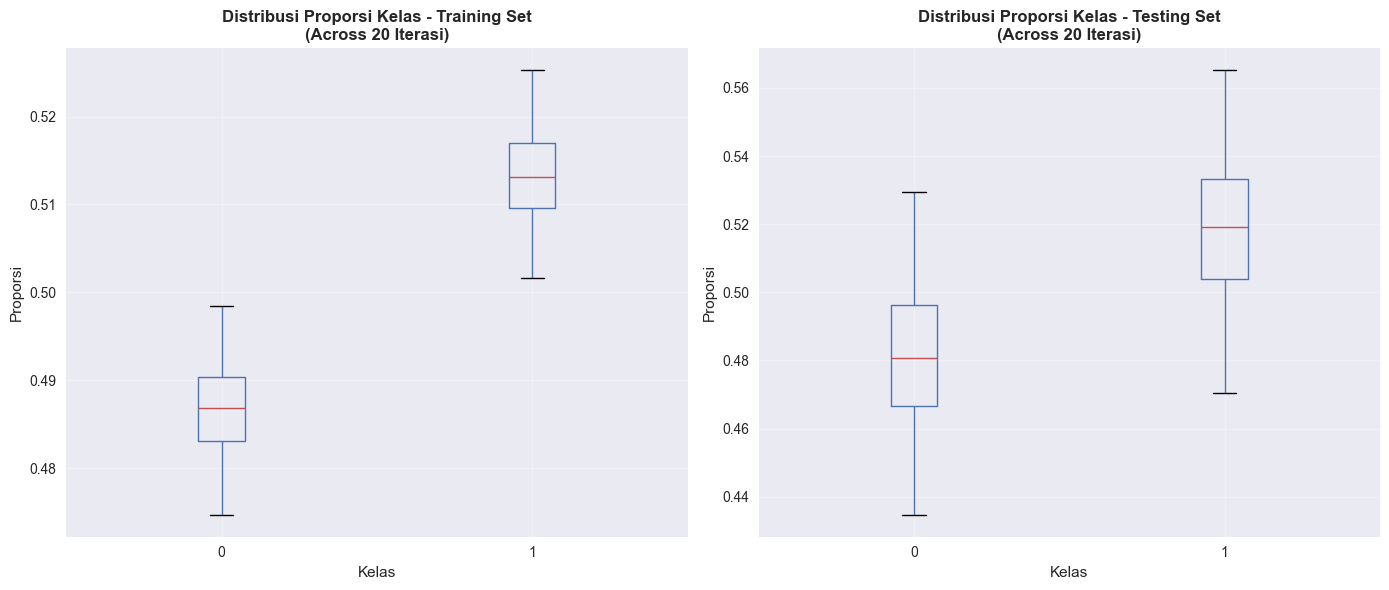


✅ Analisis distribusi kelas selesai!


In [6]:
print("="*70)
print("ANALISIS DISTRIBUSI KELAS ACROSS 20 ITERASI")
print("="*70)

# Parameters
n_iterations = 20
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

# Storage untuk proporsi kelas setiap iterasi
class_proportions = {
    'train': [],
    'test': []
}

# Hitung proporsi untuk setiap iterasi
for iteration in range(1, n_iterations + 1):
    # Split data (tanpa stratify sesuai permintaan)
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=iteration
    )
    
    # Hitung proporsi training
    train_dist = y_train.value_counts(normalize=True).sort_index()
    test_dist = y_test.value_counts(normalize=True).sort_index()
    
    class_proportions['train'].append(train_dist)
    class_proportions['test'].append(test_dist)

# Convert ke DataFrame untuk analisis
train_props_df = pd.DataFrame(class_proportions['train'])
test_props_df = pd.DataFrame(class_proportions['test'])

# Hitung statistik
print(f"📊 STATISTIK PROPORSI KELAS (Mean ± Std):")
print(f"\nTraining Set:")
for class_label in train_props_df.columns:
    mean_prop = train_props_df[class_label].mean()
    std_prop = train_props_df[class_label].std()
    print(f"  • Kelas {class_label}: {mean_prop:.3f} ± {std_prop:.3f}")

print(f"\nTesting Set:")
for class_label in test_props_df.columns:
    mean_prop = test_props_df[class_label].mean()
    std_prop = test_props_df[class_label].std()
    print(f"  • Kelas {class_label}: {mean_prop:.3f} ± {std_prop:.3f}")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training proportions
train_props_df.boxplot(ax=axes[0])
axes[0].set_title('Distribusi Proporsi Kelas - Training Set\n(Across 20 Iterasi)', fontweight='bold')
axes[0].set_ylabel('Proporsi')
axes[0].set_xlabel('Kelas')
axes[0].grid(True, alpha=0.3)

# Testing proportions  
test_props_df.boxplot(ax=axes[1])
axes[1].set_title('Distribusi Proporsi Kelas - Testing Set\n(Across 20 Iterasi)', fontweight='bold')
axes[1].set_ylabel('Proporsi')
axes[1].set_xlabel('Kelas')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Analisis distribusi kelas selesai!")

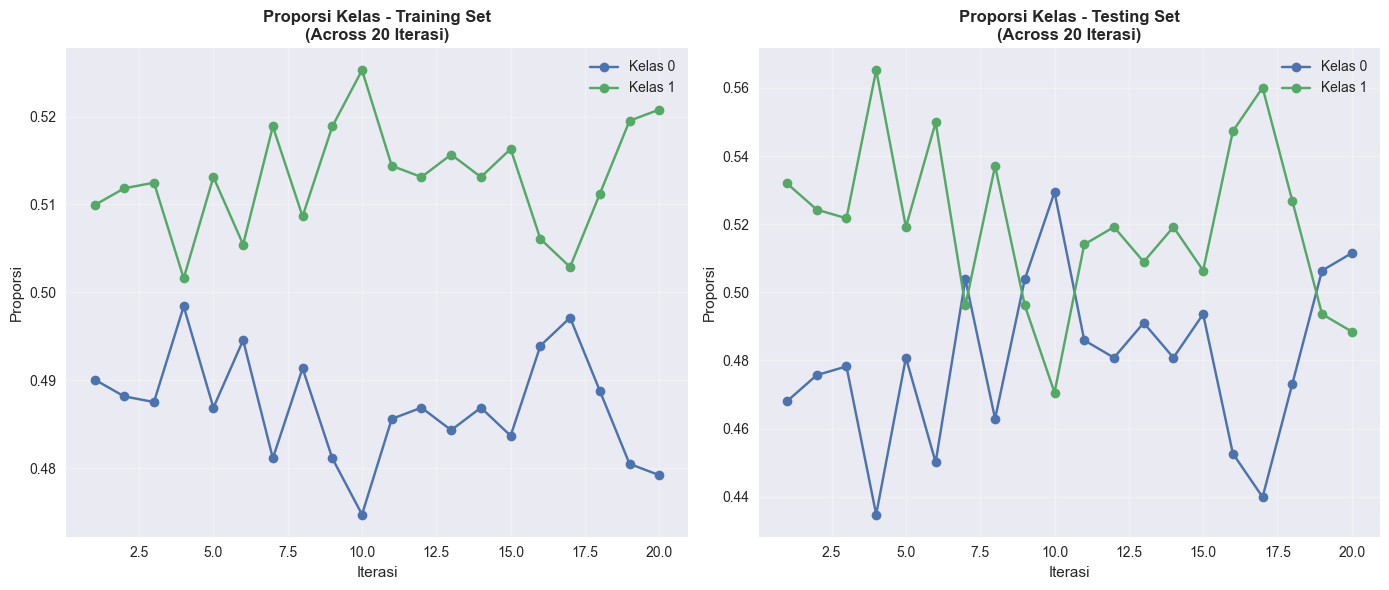

In [84]:
# Line plot untuk proporsi kelas across iterasi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
for class_label in train_props_df.columns:
    axes[0].plot(range(1, n_iterations + 1),
                 train_props_df[class_label],
                 marker='o',
                 label=f'Kelas {class_label}')
axes[0].set_title('Proporsi Kelas - Training Set\n(Across 20 Iterasi)', fontweight='bold')
axes[0].set_xlabel('Iterasi')
axes[0].set_ylabel('Proporsi')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Testing set
for class_label in test_props_df.columns:
    axes[1].plot(range(1, n_iterations + 1),
                 test_props_df[class_label],
                 marker='o',
                 label=f'Kelas {class_label}')
axes[1].set_title('Proporsi Kelas - Testing Set\n(Across 20 Iterasi)', fontweight='bold')
axes[1].set_xlabel('Iterasi')
axes[1].set_ylabel('Proporsi')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5.3 : Main Experiment - Training & Testing

In [8]:
print("="*70)
print("EKSPERIMEN KOMPARASI MANHATTAN vs JACCARD")
print("="*70)

# Storage untuk hasil
results = {
    'manhattan': {
        'train_accuracy': {k: [] for k in k_values},
        'test_accuracy': {k: [] for k in k_values}
    },
    'jaccard': {
        'train_accuracy': {k: [] for k in k_values},
        'test_accuracy': {k: [] for k in k_values}
    }
}

print(f"🔄 Menjalankan {n_iterations} iterasi untuk {len(k_values)} nilai K...")
print(f"📊 Total eksperimen: {n_iterations * len(k_values) * 2} = {n_iterations * len(k_values) * 2} model")

# Main experiment loop
for iteration in range(1, n_iterations + 1):
    print(f"\n📍 Iterasi {iteration}/{n_iterations}")
    
    # Split TF-IDF data
    X_tfidf_train, X_tfidf_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=iteration
    )
    
    # Split Binary data dengan random_state yang sama
    X_binary_train, X_binary_test, _, _ = train_test_split(
        X_binary, y, test_size=0.2, random_state=iteration
    )
    
    print(f"   📊 Train: {len(y_train)}, Test: {len(y_test)}")
    
    # Test untuk setiap nilai K
    for k in k_values:
        # ========== MANHATTAN dengan TF-IDF ==========
        knn_manhattan = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
        knn_manhattan.fit(X_tfidf_train, y_train)
        
        # Prediksi dan hitung akurasi
        train_pred_manhattan = knn_manhattan.predict(X_tfidf_train)
        test_pred_manhattan = knn_manhattan.predict(X_tfidf_test)
        
        train_acc_manhattan = accuracy_score(y_train, train_pred_manhattan)
        test_acc_manhattan = accuracy_score(y_test, test_pred_manhattan)
        
        results['manhattan']['train_accuracy'][k].append(train_acc_manhattan)
        results['manhattan']['test_accuracy'][k].append(test_acc_manhattan)
        
        # ========== JACCARD dengan Binary ==========
        
        knn_jaccard = KNeighborsClassifier(n_neighbors=k, metric='jaccard')
        knn_jaccard.fit(X_binary_train, y_train)
        
        # Prediksi dan hitung akurasi
        train_pred_jaccard = knn_jaccard.predict(X_binary_train)
        test_pred_jaccard = knn_jaccard.predict(X_binary_test)
        
        train_acc_jaccard = accuracy_score(y_train, train_pred_jaccard)
        test_acc_jaccard = accuracy_score(y_test, test_pred_jaccard)
        
        results['jaccard']['train_accuracy'][k].append(train_acc_jaccard)
        results['jaccard']['test_accuracy'][k].append(test_acc_jaccard)
    
    # Progress report setiap 5 iterasi
    if iteration % 5 == 0:
        best_manhattan_test = max(results['manhattan']['test_accuracy'][k][-1] for k in k_values)
        best_jaccard_test = max(results['jaccard']['test_accuracy'][k][-1] for k in k_values)
        print(f"   ⭐ Best Test Accuracy - Manhattan: {best_manhattan_test:.4f}, Jaccard: {best_jaccard_test:.4f}")

print("\n✅ Eksperimen selesai!")

EKSPERIMEN KOMPARASI MANHATTAN vs JACCARD
🔄 Menjalankan 20 iterasi untuk 10 nilai K...
📊 Total eksperimen: 400 = 400 model

📍 Iterasi 1/20
   📊 Train: 1563, Test: 391

📍 Iterasi 2/20
   📊 Train: 1563, Test: 391

📍 Iterasi 3/20
   📊 Train: 1563, Test: 391

📍 Iterasi 4/20
   📊 Train: 1563, Test: 391

📍 Iterasi 5/20
   📊 Train: 1563, Test: 391
   ⭐ Best Test Accuracy - Manhattan: 0.8491, Jaccard: 0.9437

📍 Iterasi 6/20
   📊 Train: 1563, Test: 391

📍 Iterasi 7/20
   📊 Train: 1563, Test: 391

📍 Iterasi 8/20
   📊 Train: 1563, Test: 391

📍 Iterasi 9/20
   📊 Train: 1563, Test: 391

📍 Iterasi 10/20
   📊 Train: 1563, Test: 391
   ⭐ Best Test Accuracy - Manhattan: 0.9105, Jaccard: 0.9463

📍 Iterasi 11/20
   📊 Train: 1563, Test: 391

📍 Iterasi 12/20
   📊 Train: 1563, Test: 391

📍 Iterasi 13/20
   📊 Train: 1563, Test: 391

📍 Iterasi 14/20
   📊 Train: 1563, Test: 391

📍 Iterasi 15/20
   📊 Train: 1563, Test: 391
   ⭐ Best Test Accuracy - Manhattan: 0.8772, Jaccard: 0.9463

📍 Iterasi 16/20
   📊 Train:

In [9]:
print("="*70)
print("PEMBUATAN TABEL AKURASI LENGKAP")
print("="*70)

def create_accuracy_table(results_dict, metric_name, accuracy_type):
    """
    Membuat DataFrame tabel akurasi 20x10 (iterasi x k_values)
    """
    data = []
    for iteration in range(n_iterations):
        row = []
        for k in k_values:
            accuracy = results_dict[accuracy_type][k][iteration]
            row.append(f"{accuracy:.4f}")
        data.append(row)
    
    df = pd.DataFrame(data, 
                     columns=[f'K={k}' for k in k_values],
                     index=[f'Iter_{i+1}' for i in range(n_iterations)])
    return df

# Buat semua tabel
tables = {}

# Manhattan Tables
tables['manhattan_train'] = create_accuracy_table(
    results['manhattan'], 'Manhattan', 'train_accuracy'
)
tables['manhattan_test'] = create_accuracy_table(
    results['manhattan'], 'Manhattan', 'test_accuracy'
)

# Jaccard Tables
tables['jaccard_train'] = create_accuracy_table(
    results['jaccard'], 'Jaccard', 'train_accuracy'
)
tables['jaccard_test'] = create_accuracy_table(
    results['jaccard'], 'Jaccard', 'test_accuracy'
)

# Display tables
print("📋 TABEL 1: MANHATTAN TRAINING ACCURACY")
print(tables['manhattan_train'])
print("\n" + "="*100)

print("📋 TABEL 2: MANHATTAN TESTING ACCURACY")
print(tables['manhattan_test'])
print("\n" + "="*100)

print("📋 TABEL 3: JACCARD TRAINING ACCURACY")
print(tables['jaccard_train'])
print("\n" + "="*100)

print("📋 TABEL 4: JACCARD TESTING ACCURACY")  
print(tables['jaccard_test'])

# Export ke CSV
export_choice = input("\n💾 Export tabel ke CSV files? (y/n): ")
if export_choice.lower() == 'y':
    tables['manhattan_train'].to_csv('manhattan_training_accuracy.csv')
    tables['manhattan_test'].to_csv('manhattan_testing_accuracy.csv')
    tables['jaccard_train'].to_csv('jaccard_training_accuracy.csv')
    tables['jaccard_test'].to_csv('jaccard_testing_accuracy.csv')
    print("✅ Semua tabel berhasil di-export!")

PEMBUATAN TABEL AKURASI LENGKAP
📋 TABEL 1: MANHATTAN TRAINING ACCURACY
            K=1     K=3     K=5     K=7     K=9    K=11    K=13    K=15  \
Iter_1   1.0000  0.8983  0.8848  0.8752  0.8669  0.8554  0.8554  0.8324   
Iter_2   0.9994  0.8957  0.8682  0.8554  0.8471  0.8426  0.8464  0.8413   
Iter_3   0.9987  0.8989  0.8663  0.8624  0.8490  0.8522  0.8503  0.8484   
Iter_4   0.9987  0.8996  0.8612  0.8490  0.8567  0.8337  0.8612  0.8599   
Iter_5   0.9994  0.8957  0.8637  0.8560  0.8528  0.8528  0.8433  0.8388   
Iter_6   1.0000  0.8951  0.8650  0.8567  0.8535  0.8484  0.8535  0.8464   
Iter_7   0.9987  0.8970  0.8708  0.8599  0.8599  0.8541  0.8592  0.8541   
Iter_8   0.9994  0.8868  0.8804  0.8701  0.8599  0.8605  0.8548  0.8528   
Iter_9   0.9987  0.8996  0.8714  0.8560  0.8548  0.8477  0.8439  0.8439   
Iter_10  0.9987  0.8900  0.8580  0.8567  0.8496  0.8413  0.8407  0.8317   
Iter_11  0.9987  0.8938  0.8592  0.8516  0.8458  0.8413  0.8388  0.8317   
Iter_12  0.9987  0.8951  0.85

## 5.4 Statistical Analysis & Summary

VISUALISASI HASIL EKSPERIMEN


NameError: name 'manhattan_summary' is not defined

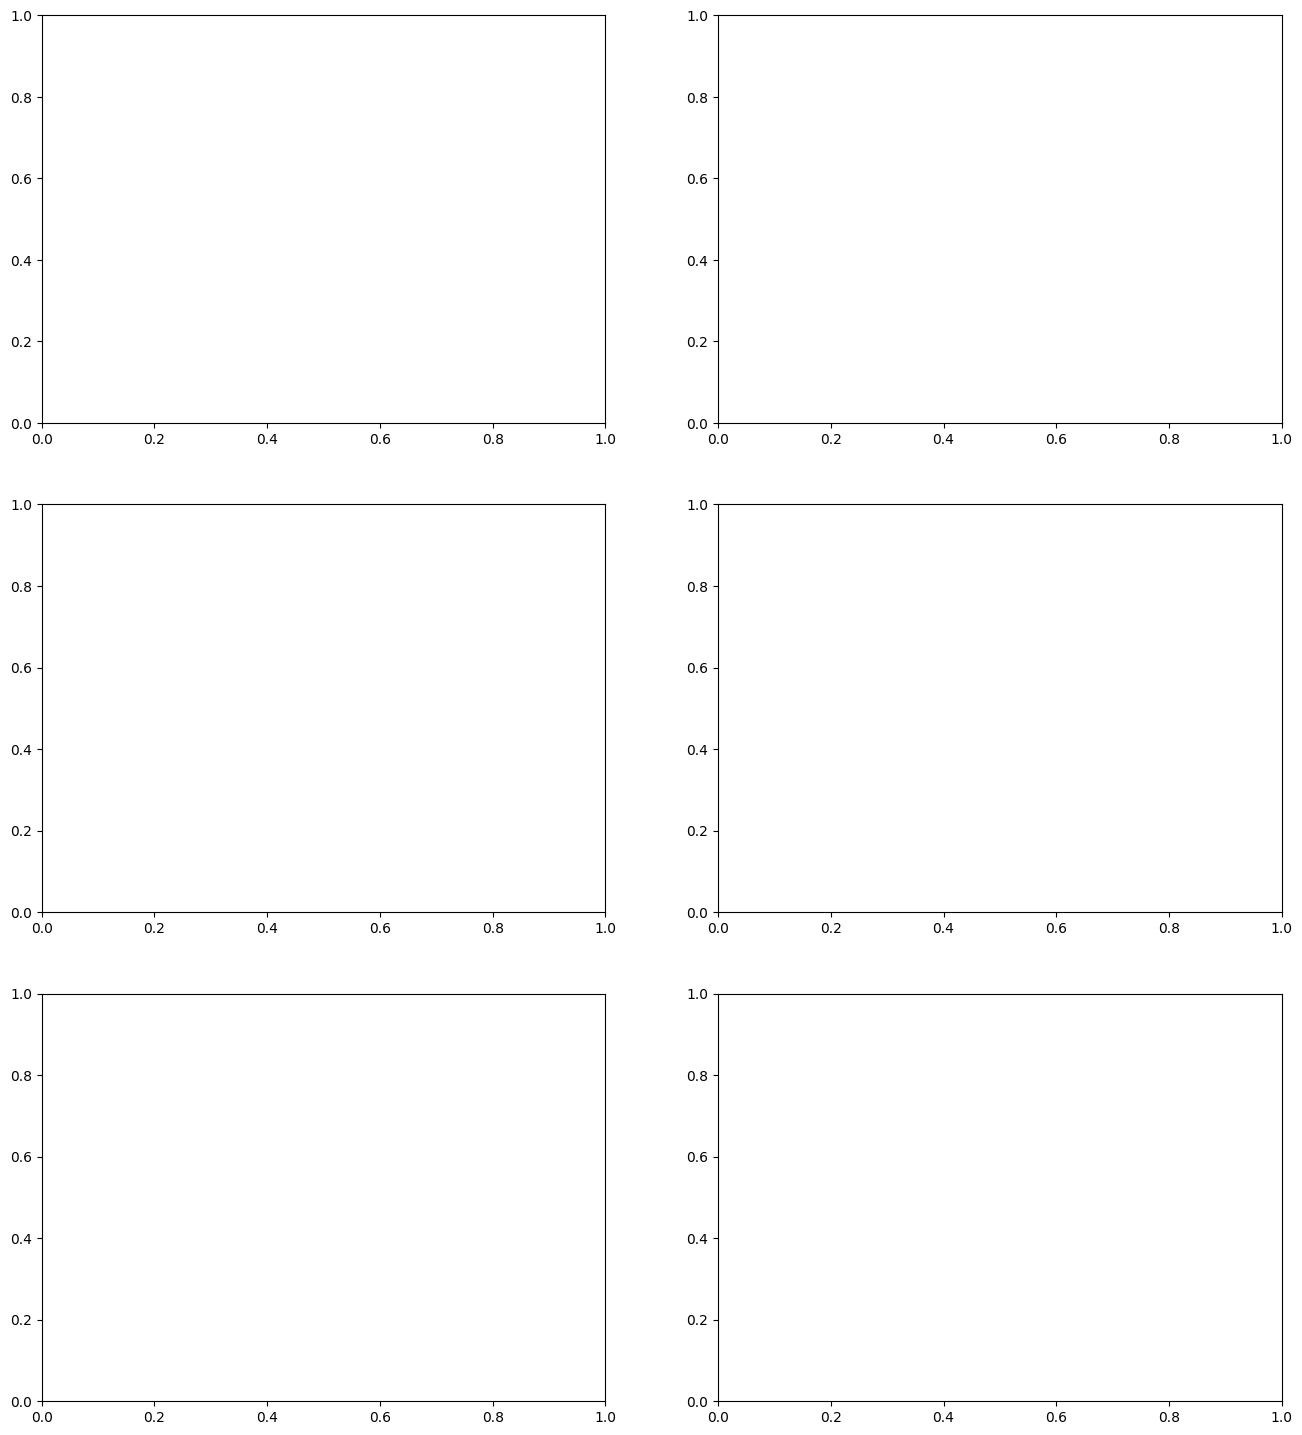

In [ ]:
print("="*70)
print("ANALISIS STATISTIK HASIL EKSPERIMEN")
print("="*70)

# Fungsi untuk menghitung statistik
def calculate_statistics(results_dict, accuracy_type):
    """
    Menghitung mean, std, min, max untuk setiap K
    """
    stats = {}
    for k in k_values:
        accuracies = results_dict[accuracy_type][k]
        stats[k] = {
            'mean': np.mean(accuracies),
            'std': np.std(accuracies, ddof=1),
            'min': np.min(accuracies),
            'max': np.max(accuracies)
        }
    return stats

# Hitung statistik untuk semua kombinasi
manhattan_train_stats = calculate_statistics(results['manhattan'], 'train_accuracy')
manhattan_test_stats = calculate_statistics(results['manhattan'], 'test_accuracy')
jaccard_train_stats = calculate_statistics(results['jaccard'], 'train_accuracy')
jaccard_test_stats = calculate_statistics(results['jaccard'], 'test_accuracy')

# Buat summary table
def create_summary_table(train_stats, test_stats, method_name):
    """
    Membuat tabel ringkasan statistik
    """
    summary_data = []
    for k in k_values:
        row = {
            'K': k,
            'Train_Mean': f"{train_stats[k]['mean']:.4f}",
            'Train_Std': f"{train_stats[k]['std']:.4f}",
            'Train_Range': f"{train_stats[k]['min']:.4f}-{train_stats[k]['max']:.4f}",
            'Test_Mean': f"{test_stats[k]['mean']:.4f}",
            'Test_Std': f"{test_stats[k]['std']:.4f}",
            'Test_Range': f"{test_stats[k]['min']:.4f}-{test_stats[k]['max']:.4f}"
        }
        summary_data.append(row)
    
    return pd.DataFrame(summary_data)

# Generate summary tables
manhattan_summary = create_summary_table(manhattan_train_stats, manhattan_test_stats, 'Manhattan')
jaccard_summary = create_summary_table(jaccard_train_stats, jaccard_test_stats, 'Jaccard')

print("📊 RINGKASAN STATISTIK MANHATTAN (TF-IDF)")
print(manhattan_summary.to_string(index=False))

print("\n📊 RINGKASAN STATISTIK JACCARD (BINARY)")
print(jaccard_summary.to_string(index=False))

# Find best configurations
best_manhattan_test = max(manhattan_test_stats.items(), key=lambda x: x[1]['mean'])
best_jaccard_test = max(jaccard_test_stats.items(), key=lambda x: x[1]['mean'])

print(f"\n🏆 KONFIGURASI TERBAIK:")
print(f"Manhattan (TF-IDF):")
print(f"  • K optimal: {best_manhattan_test[0]}")
print(f"  • Test accuracy: {best_manhattan_test[1]['mean']:.4f} ± {best_manhattan_test[1]['std']:.4f}")

print(f"\nJaccard (Binary):")
print(f"  • K optimal: {best_jaccard_test[0]}")
print(f"  • Test accuracy: {best_jaccard_test[1]['mean']:.4f} ± {best_jaccard_test[1]['std']:.4f}")

# Export summary
export_summary = input("\n💾 Export summary statistics ke CSV? (y/n): ")
if export_summary.lower() == 'y':
    manhattan_summary.to_csv('manhattan_summary_statistics.csv', index=False)
    jaccard_summary.to_csv('jaccard_summary_statistics.csv', index=False)
    print("✅ Summary statistics berhasil di-export!")

## 5.5 Comprehensive Visualization

In [ ]:
print("="*70)
print("VISUALISASI KOMPREHENSIF HASIL EKSPERIMEN")
print("="*70)

# Setup plotting
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('ANALISIS KOMPARASI: MANHATTAN (TF-IDF) vs JACCARD (BINARY) PADA KNN', 
             fontsize=16, fontweight='bold', y=0.98)

# Prepare data for plotting
manhattan_test_means = [manhattan_test_stats[k]['mean'] for k in k_values]
manhattan_test_stds = [manhattan_test_stats[k]['std'] for k in k_values]
jaccard_test_means = [jaccard_test_stats[k]['mean'] for k in k_values]
jaccard_test_stds = [jaccard_test_stats[k]['std'] for k in k_values]

manhattan_train_means = [manhattan_train_stats[k]['mean'] for k in k_values]
jaccard_train_means = [jaccard_train_stats[k]['mean'] for k in k_values]

# 1. Bar Chart Comparison (Test Accuracy)
ax1 = axes[0, 0]
x_pos = np.arange(len(k_values))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, manhattan_test_means, width, 
               yerr=manhattan_test_stds, capsize=5,
               label='Manhattan (TF-IDF)', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, jaccard_test_means, width,
               yerr=jaccard_test_stds, capsize=5,
               label='Jaccard (Binary)', color='#A23B72', alpha=0.8)

ax1.set_xlabel('Nilai K')
ax1.set_ylabel('Test Accuracy (Mean ± Std)')
ax1.set_title('Perbandingan Test Accuracy', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(k_values)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Line Plot Trend (Test vs Training)
ax2 = axes[0, 1]
ax2.plot(k_values, manhattan_test_means, 'o-', linewidth=2.5, markersize=8,
         color='#2E86AB', label='Manhattan Test')
ax2.plot(k_values, manhattan_train_means, 's--', linewidth=2, markersize=6,
         color='#2E86AB', alpha=0.6, label='Manhattan Train')
ax2.plot(k_values, jaccard_test_means, 'o-', linewidth=2.5, markersize=8,
         color='#A23B72', label='Jaccard Test')
ax2.plot(k_values, jaccard_train_means, 's--', linewidth=2, markersize=6,
         color='#A23B72', alpha=0.6, label='Jaccard Train')

ax2.set_xlabel('Nilai K')
ax2.set_ylabel('Accuracy')
ax2.set_title('Trend Accuracy: Training vs Testing', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Box Plot Distribution (Test Accuracy)
ax3 = axes[1, 0]
manhattan_test_data = [results['manhattan']['test_accuracy'][k] for k in k_values]
jaccard_test_data = [results['jaccard']['test_accuracy'][k] for k in k_values]

bp1 = ax3.boxplot(manhattan_test_data, positions=x_pos - width/2, widths=width*0.8,
                  patch_artist=True, showmeans=True)
bp2 = ax3.boxplot(jaccard_test_data, positions=x_pos + width/2, widths=width*0.8,
                  patch_artist=True, showmeans=True)

for patch in bp1['boxes']:
    patch.set_facecolor('#2E86AB')
    patch.set_alpha(0.6)
for patch in bp2['boxes']:
    patch.set_facecolor('#A23B72')
    patch.set_alpha(0.6)

ax3.set_xlabel('Nilai K')
ax3.set_ylabel('Test Accuracy Distribution')
ax3.set_title('Distribusi Test Accuracy (20 Iterasi)', fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(k_values)

# 4. Difference Analysis
ax4 = axes[1, 1]
accuracy_differences = [manhattan_test_means[i] - jaccard_test_means[i] 
                       for i in range(len(k_values))]
colors = ['green' if diff > 0 else 'red' for diff in accuracy_differences]

bars = ax4.bar(x_pos, accuracy_differences, color=colors, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Nilai K')
ax4.set_ylabel('Selisih Accuracy (Manhattan - Jaccard)')
ax4.set_title('Analisis Selisih Performance', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(k_values)
ax4.grid(axis='y', alpha=0.3)

# 5. Variance Analysis
ax5 = axes[2, 0]
manhattan_variance = [manhattan_test_stats[k]['std'] for k in k_values]
jaccard_variance = [jaccard_test_stats[k]['std'] for k in k_values]

ax5.plot(k_values, manhattan_variance, 'o-', linewidth=2.5, markersize=8,
         color='#2E86AB', label='Manhattan Std')
ax5.plot(k_values, jaccard_variance, 's-', linewidth=2.5, markersize=8,
         color='#A23B72', label='Jaccard Std')

ax5.set_xlabel('Nilai K')
ax5.set_ylabel('Standard Deviation')
ax5.set_title('Analisis Stabilitas (Variance)', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Performance Summary Table
ax6 = axes[2, 1]
ax6.axis('tight')
ax6.axis('off')

# Prepare summary data
summary_table_data = []
for i, k in enumerate(k_values):
    manhattan_acc = f"{manhattan_test_means[i]:.4f}"
    jaccard_acc = f"{jaccard_test_means[i]:.4f}"
    diff = manhattan_test_means[i] - jaccard_test_means[i]
    winner = 'Manhattan' if diff > 0.001 else 'Jaccard' if diff < -0.001 else 'Tie'
    
    summary_table_data.append([k, manhattan_acc, jaccard_acc, f"{diff:+.4f}", winner])

table = ax6.table(cellText=summary_table_data,
                 colLabels=['K', 'Manhattan', 'Jaccard', 'Difference', 'Winner'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.8)

# Color header
for i in range(5):
    table[(0, i)].set_facecolor('#3D5A80')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax6.set_title('Ringkasan Performance Comparison', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✅ Visualisasi lengkap berhasil dibuat!")

## 5.6 Final Report & Export

print("="*70)
print("LAPORAN AKHIR EKSPERIMEN")
print("="*70)

# Overall analysis
overall_manhattan = np.mean([manhattan_test_stats[k]['mean'] for k in k_values])
overall_jaccard = np.mean([jaccard_test_stats[k]['mean'] for k in k_values])

manhattan_wins = sum(1 for i in range(len(k_values)) 
                    if manhattan_test_means[i] > jaccard_test_means[i])
jaccard_wins = len(k_values) - manhattan_wins

print(f"📊 HASIL KESELURUHAN:")
print(f"• Rata-rata Test Accuracy Manhattan: {overall_manhattan:.4f}")
print(f"• Rata-rata Test Accuracy Jaccard: {overall_jaccard:.4f}")
print(f"• Manhattan unggul di: {manhattan_wins}/{len(k_values)} nilai K")
print(f"• Jaccard unggul di: {jaccard_wins}/{len(k_values)} nilai K")

print(f"\n🏆 KONFIGURASI OPTIMAL:")
print(f"• Manhattan: K={best_manhattan_test[0]} dengan accuracy {best_manhattan_test[1]['mean']:.4f}")
print(f"• Jaccard: K={best_jaccard_test[0]} dengan accuracy {best_jaccard_test[1]['mean']:.4f}")

print(f"\n📈 ANALISIS STABILITAS:")
avg_manhattan_std = np.mean([manhattan_test_stats[k]['std'] for k in k_values])
avg_jaccard_std = np.mean([jaccard_test_stats[k]['std'] for k in k_values])
print(f"• Rata-rata Standard Deviation Manhattan: {avg_manhattan_std:.4f}")
print(f"• Rata-rata Standard Deviation Jaccard: {avg_jaccard_std:.4f}")
print(f"• Metrik lebih stabil: {'Manhattan' if avg_manhattan_std < avg_jaccard_std else 'Jaccard'}")

# Kesimpulan
print(f"\n✍️ KESIMPULAN UNTUK SKRIPSI:")
if overall_manhattan > overall_jaccard:
    winner = "Manhattan dengan representasi TF-IDF"
    margin = overall_manhattan - overall_jaccard
else:
    winner = "Jaccard dengan representasi Binary"
    margin = overall_jaccard - overall_manhattan

print(f"Berdasarkan eksperimen dengan 20 iterasi dan 10 nilai K yang berbeda,")
print(f"{winner} menunjukkan performa lebih baik dengan")
print(f"selisih rata-rata accuracy sebesar {margin:.4f} ({margin*100:.2f}%).")

# Create comprehensive results DataFrame for export
comprehensive_results = pd.DataFrame({
    'K': k_values,
    'Manhattan_Test_Mean': [f"{manhattan_test_stats[k]['mean']:.4f}" for k in k_values],
    'Manhattan_Test_Std': [f"{manhattan_test_stats[k]['std']:.4f}" for k in k_values],
    'Manhattan_Train_Mean': [f"{manhattan_train_stats[k]['mean']:.4f}" for k in k_values],
    'Jaccard_Test_Mean': [f"{jaccard_test_stats[k]['mean']:.4f}" for k in k_values],
    'Jaccard_Test_Std': [f"{jaccard_test_stats[k]['std']:.4f}" for k in k_values],
    'Jaccard_Train_Mean': [f"{jaccard_train_stats[k]['mean']:.4f}" for k in k_values],
    'Difference': [f"{manhattan_test_means[i] - jaccard_test_means[i]:+.4f}" for i in range(len(k_values))],
    'Winner': ['Manhattan' if manhattan_test_means[i] > jaccard_test_means[i] else 'Jaccard' 
              for i in range(len(k_values))]
})

print(f"\n📋 TABEL KOMPREHENSIF HASIL:")
print(comprehensive_results.to_string(index=False))

# Final export
final_export = input(f"\n💾 Export hasil komprehensif ke 'comprehensive_results.csv'? (y/n): ")
if final_export.lower() == 'y':
    comprehensive_results.to_csv('comprehensive_results.csv', index=False)
    
    # Export class proportion analysis
    class_prop_summary = pd.DataFrame({
        'Dataset': ['Training', 'Testing'],
        'Class_0_Mean': [train_props_df[0].mean(), test_props_df[0].mean()],
        'Class_0_Std': [train_props_df[0].std(), test_props_df[0].std()],
        'Class_1_Mean': [train_props_df[1].mean(), test_props_df[1].mean()],
        'Class_1_Std': [train_props_df[1].std(), test_props_df[1].std()]
    })
    class_prop_summary.to_csv('class_proportion_analysis.csv', index=False)
    
    print("✅ Semua hasil berhasil di-export!")
    print("📁 Files yang dibuat:")
    print("   • comprehensive_results.csv")
    print("   • class_proportion_analysis.csv")
    print("   • manhattan_training_accuracy.csv")
    print("   • manhattan_testing_accuracy.csv") 
    print("   • jaccard_training_accuracy.csv")
    print("   • jaccard_testing_accuracy.csv")
    print("   • manhattan_summary_statistics.csv")
    print("   • jaccard_summary_statistics.csv")

print(f"\n🎓 EKSPERIMEN SKRIPSI SELESAI!")
print(f"Total model yang dilatih: {n_iterations * len(k_values) * 2}")
print(f"Semua hasil siap untuk dimasukkan ke Bab 4 (Hasil dan Pembahasan)")